In [1]:
from tensorflow.keras.applications import ResNet50
import os
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import torch
import sys
sys.path.append('..')  
from custom_transformers import *
import tensorflow as tf
import matplotlib.pyplot as plt
from augmentation_generator_batch_size import *
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
def seed_everything(seed: int=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


seed_everything(51)

In [3]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(X_train, Y_train), (X_test, Y_test) = fashion_mnist.load_data()

X_train = np.expand_dims(X_train, -1)
X_test = np.expand_dims(X_test, -1)

# Konwersja do RGB
X_train = np.repeat(X_train, 3, axis=-1)
X_test = np.repeat(X_test, 3, axis=-1)

print(f"X_train.shape: {X_train.shape} \nY_train.shape: {Y_train.shape} \nX_test.shape: {X_test.shape} \nY_test.shape: {Y_test.shape}")

X_train.shape: (60000, 28, 28, 3) 
Y_train.shape: (60000,) 
X_test.shape: (10000, 28, 28, 3) 
Y_test.shape: (10000,)


In [4]:
random_pixels_cutout = RandomPixelCutout(max_cutout_size=0.05, color=True)
generator = AugmentedCIFAR10Generator(X_train, Y_train, batch_size=16, shuffle=True, augmentor= random_pixels_cutout, augment_fraction=0.2, overwrite=False)

batch_x, batch_y = generator[0]

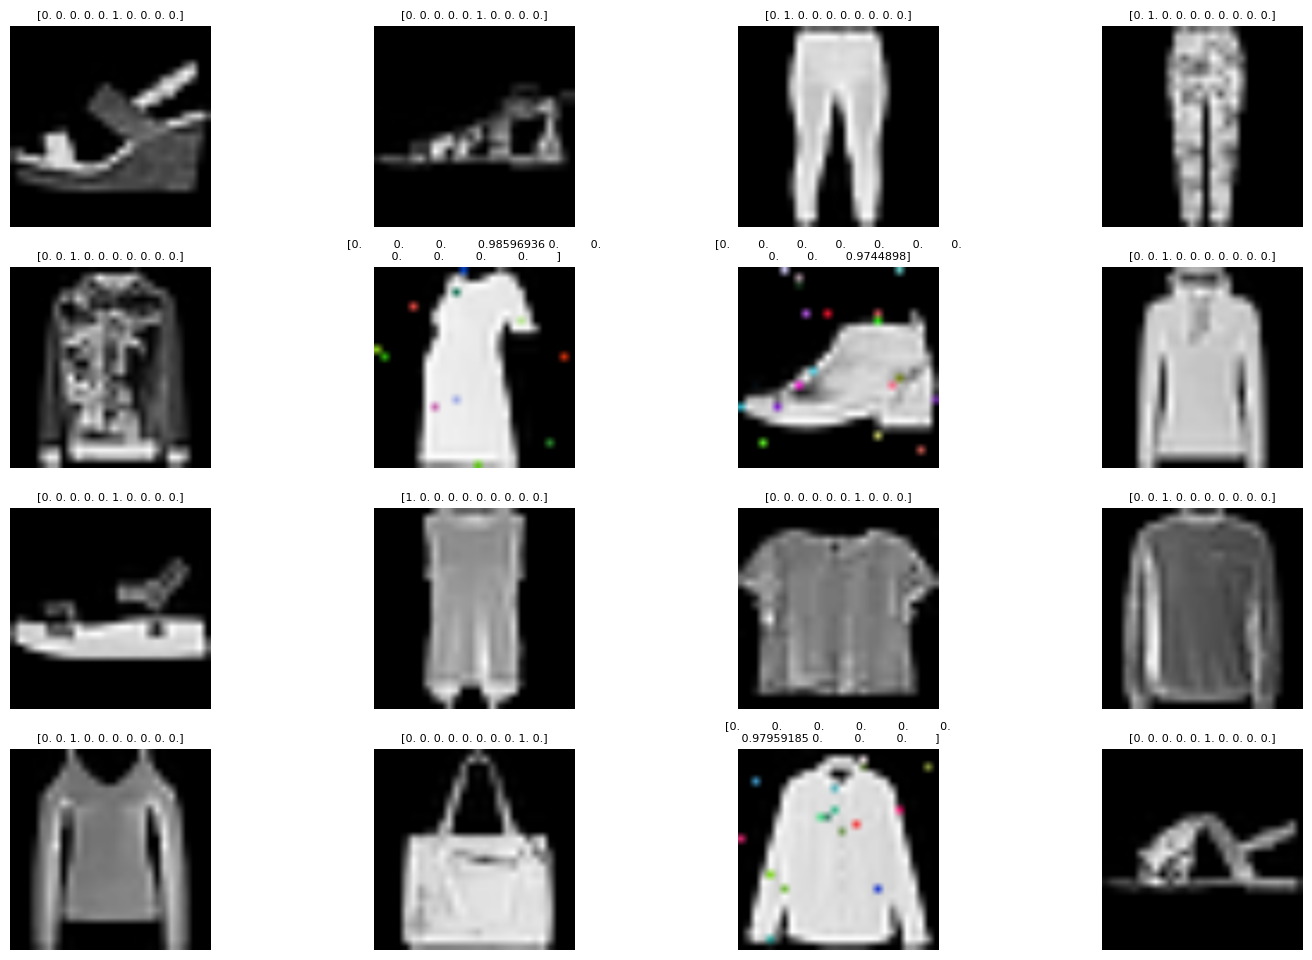

In [5]:
def denormalize_resnet(x):
    x = x.copy()
    x[..., 0] += 103.939  # Blue
    x[..., 1] += 116.779  # Green
    x[..., 2] += 123.68   # Red
    x = x[..., ::-1]
    x = np.clip(x / 255.0, 0, 1)
    return x

n = len(batch_x)
cols = 4
rows = n//cols + int(n%cols != 0)

fig, axes = plt.subplots(rows, cols, figsize=(18, 12))
if rows == 1 or cols == 1:
    axes = np.expand_dims(axes, axis=0)
for i in range(len(batch_x)):
    row = i // cols
    col = i % cols
    ax = axes[row, col]
    ax.imshow(denormalize_resnet(batch_x[i]))
    ax.set_title(batch_y[i], fontsize=8)
    ax.axis('off')

## Restnet Train 

In [6]:
random_pixels_cutout= RandomPixelCutout(max_cutout_size=0.05, color=False)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(10, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

train_gen = AugmentedCIFAR10Generator(X_train, Y_train, batch_size=32,
    augmentor=random_pixels_cutout, augment_fraction=0.2, overwrite=False)

test_gen = AugmentedCIFAR10Generator(X_test, Y_test,
    batch_size=32, shuffle=False, augmentor=None)


model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(train_gen, validation_data=test_gen, epochs=5)

Epoch 1/5


c:\Users\rogal\anaconda3\envs\myenv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2250/2250 ━━━━━━━━━━━━━━━━━━━━ 3227s 1s/step - accuracy: 0.7765 - loss: 0.6474 - val_accuracy: 0.8780 - val_loss: 0.3424
Epoch 2/5
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 2826s 1s/step - accuracy: 0.8371 - loss: 0.4495 - val_accuracy: 0.8669 - val_loss: 0.3888
Epoch 3/5
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 2814s 1s/step - accuracy: 0.8082 - loss: 0.8276 - val_accuracy: 0.8431 - val_loss: 1.0240
Epoch 4/5
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 2812s 1s/step - accuracy: 0.7896 - loss: 2.1882 - val_accuracy: 0.8626 - val_loss: 1.7768
Epoch 5/5
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 2815s 1s/step - accuracy: 0.7801 - loss: 4.9399 - val_accuracy: 0.8574 - val_loss: 3.9410


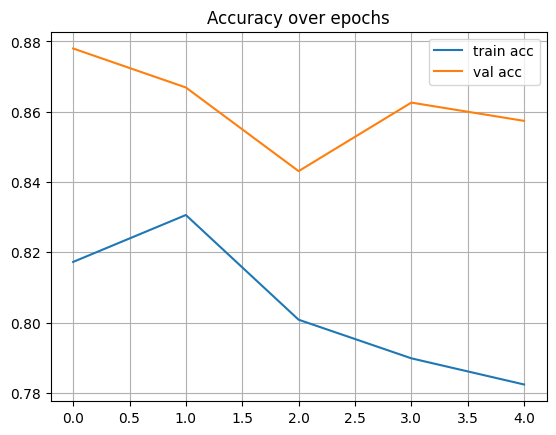

In [7]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title("Accuracy over epochs")
plt.grid(True)
plt.show()

Final test accuracy : 0.857

In [8]:
model.save("restnet_random_mnist1.keras")